# boundary_conditions

> Create slip-wall boundary conditions, create initial conditions for "primitive streak" (disk), and "germ band" (rectangle), and run simulations with patterned feedback parameter


In [ ]:
#| default_exp boundary

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
from CE_simulation.triangle import *
from CE_simulation.tension import *
from CE_simulation.delaunay import *
from CE_simulation.isogonal import *

In [ ]:
#| export
import os
import sys
import importlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from numpy import sin, cos, tan, pi, sqrt, arccos, arctan, arctan2
from numpy.linalg import norm

from scipy.integrate import solve_ivp
from scipy import ndimage
from scipy import spatial
from scipy import optimize

from tqdm.notebook import tqdm

from copy import deepcopy

from collections import Counter

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable, Callable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import ipywidgets as widgets
from matplotlib import animation, rc

In [ ]:
#| export

import autograd.numpy as anp  # Thinly-wrapped numpy
from autograd import grad as agrad

## Slip walls

Two possibilities:
1. For walls || to the $x,y$-axis, we can fix the positions of the vertices and leave out the corresponding
coordinate from the optimization routine
2. For all other, it is probably best to implement a suitable potential trap for the boundary vertices. Else one will have to use constrained constrained minimization algorithms, which is annoying could degrade performance.

A boundary is implemented with 2 functions:

1. `bdry_ids`: list of `_fid`. Used to create an array which selects the boundary entries from the array of vertex positions.
2. `bdry_penalty_fct`: `coords` -> penalty. Vectorized. 

Multiple boundaries can be added by passing a list of boundaries.

Next, implement 'frozen' slip walls, where the x or y coordinate of a subset of vertices is fixed. This is again given by 2 datapoints:
- bdry_ids: list of id lists, one id list for each bdry component
- bdry_values: pairs (0/1, float). 0/1 stands for x, y axis

Need to avoid assigning into arrays, which might raise autograd issues. So use masks and multiplication instead.

In [ ]:
#| export

def mat_inv_2d(mat):
    """mat.shape = (i,j, ...)"""
    inv = 1/(mat[0,0]*mat[1,1]-mat[0,1]*mat[1,0])*anp.stack([[mat[1,1], -mat[0,1]],[-mat[1,0], mat[0,0]]])
    return inv

In [ ]:
# to do: unify into one function

In [ ]:
#| export

@patch
def get_primal_energy_fct_cells_bdry(self: HalfEdgeMesh, mod_bulk=1, mod_shear=.01, angle_penalty=100,
                                     reg_bulk=0, A0=sqrt(3)/2, epsilon_l=1e-5,
                                     bdry_penalty=20, bdry_ids=None, bdry_penalty_fcts=None, bdry_coords=None):
    """Get function to compute primal energy from primal vertices. Cell based shape tensor.
    bdry_penalty_fcts: (2, n_vertices) -> energy. Also replaced it by scale invariant energy.
    """
    bdry_method = None
    if bdry_penalty_fcts is not None:
        bdry_method = "penalty"
    elif bdry_coords is not None:
        bdry_method = "frozen"

    if bdry_ids is None:
        bdry_ids = []
        bdry_penalty_fcts = []
        bdry_coords = []
    # book-keeping
    face_keys = sorted(self.faces.keys())
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    n_faces = len(self.faces)
    
    # for bdry
    bdry_masks = [anp.array([(fid in ids) for fid in face_keys]) for ids in bdry_ids]
    bdry_ids = [anp.stack([face_key_dict[fid] for fid in ids]) for ids in bdry_ids]

    # stuff for the shape tensor energy
    cell_list = []
    rest_shapes = []
    for v in self.vertices.values():    # iterate around vertex.
        neighbors = v.get_face_neighbors()
        if not (None in neighbors):
            cell = [face_key_dict[fc._fid] for fc in neighbors]
            cell_list.append(cell)
            rest_shapes.append(v.rest_shape)
    valences = [len(cell) for cell in cell_list]
    max_valence = max(valences)
    valence_mask = anp.array([x*[0,]+(max_valence-x)*[1,] for x in valences])
    cell_list = anp.array([anp.pad(cell, (0, max_valence-len(cell)), mode="edge") for cell in cell_list])
    rest_shapes = anp.stack(rest_shapes)

    # stuff for the angle penalty
    e_dual = [] # dual vertices do not move during optimization, so collect the actual edges
    e_lst_primal = [] # for primal, collect the indices

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            # rotate by 90 degrees
            dual_edge = anp.array([dual_edge[1], -dual_edge[0]])
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = [face_key_dict[fc._fid] for fc in [he.face, he.twin.face]] # 0= he, 1= twin
            e_dual.append(dual_edge)
            e_lst_primal.append(primal_edge)
    e_dual = anp.array(e_dual)
    e_lst_primal = anp.array(e_lst_primal)
    
    # breaking translational invariance.
    center = anp.mean([v.coords for v in self.vertices.values()], axis=0)
    
    def get_E(x0):
        x, y = (x0[:n_faces], x0[n_faces:])
        # freeze boundary
        if bdry_method == "frozen":
            for msk, coord in zip(bdry_masks, bdry_coords):
                if coord[0] == "x":
                    x = x*(1-msk) + msk*coord[1]
                elif coord[0] == "y":
                    y = y*(1-msk) + msk*coord[1]
        pts = anp.stack([x, y], axis=-1)
        # face-based shape energy
        cells = anp.stack([pts[i] for i in cell_list.T], axis=0)
        edges = cells - anp.roll(cells, 1, axis=0)
        lengths = anp.linalg.norm((edges.T + valence_mask).T, axis=-1) + 10*epsilon_l
        # stupid hack to avoid 0-division error due to padding in the jacobian
        units = (edges.T/lengths.T).T
        tensors = anp.einsum('efi,efj->fij', edges, units) 
        delta = tensors - rest_shapes
        #delta = anp.einsum('ijf, fjk->fik', mat_inv_2d(rest_shapes.T), tensors) - anp.eye(2)
        E_shape = (mod_shear*4*anp.mean(delta**2)
                   + mod_bulk*anp.mean((delta[:,0,0]+delta[:,1,1])**2))
        # regularize with the vertex model energy
        if reg_bulk > 0:
            E_vertex = reg_bulk*anp.mean((polygon_area(cells)-A0)**2)
        else:
            E_vertex = 0
        # angle penalty
        pts = anp.stack([x, y], axis=-1)
        e_primal = pts[e_lst_primal[:,1]] - pts[e_lst_primal[:,0]] # he.twin.face-he.face
        lengths = anp.linalg.norm(e_primal, axis=-1) 
        # + epsilon to avoid 0-division error and make penalty smooth as length passes through 0
        # makes energy barrier so need epsilon small!
        penalty = (1-anp.einsum('ei,ei->e', e_primal, e_dual)/(lengths+epsilon_l))
        E_angle = angle_penalty * anp.mean(penalty) 
        # break translation symmetry
        E_trans = 1/2*((anp.mean(x)-center[0])**2+(anp.mean(y)-center[0]))**2
        # boundary energy
        E_bdry = 0
        if bdry_method == "penalty":
            for ids, fct in zip(bdry_ids, bdry_penalty_fcts):
                E_bdry = E_bdry+bdry_penalty*anp.mean(fct(pts[ids,:].T))
        return E_angle + E_shape + E_vertex + E_trans + E_bdry
    
    return get_E, agrad(get_E)

In [ ]:
#| export

@patch
def set_bdry(self: HalfEdgeMesh, bdry_ids, bdry_coords):
    for bdry, coord in zip(bdry_ids, bdry_coords):
        for fcid in bdry:
            if coord[0] =="x":
                self.faces[fcid].dual_coords[0] = coord[1]
            elif coord[0] =="y":
                self.faces[fcid].dual_coords[1] = coord[1]

In [ ]:
# also add method to diagnose how well boundary cond is obeyed

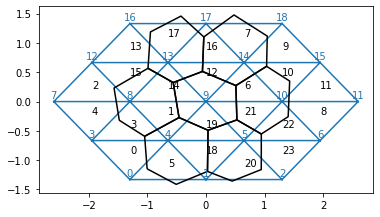

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=5, nx=5)

mesh.set_voronoi()
mesh.set_rest_lengths()

scale = 1 # just to demonstrate scale invariance of the energy
mesh.transform_dual_vertices(lambda x: scale*x)
for v in mesh.vertices.values():
    v.rest_shape = scale*sqrt(3)*np.eye(2)

mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.05*scale))
mesh.transform_vertices(lambda x: shear_mat(1.3)@x+np.random.normal(size=2, scale=.0))

mesh.cellplot()
mesh.triplot()
mesh.labelplot(face_labels=True)

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
mesh.get_shape_energy(mod_bulk=1, mod_shear=.1)

{0: None,
 1: None,
 2: None,
 3: None,
 4: 0.02468483009262956,
 5: 0.02715055693347458,
 6: None,
 7: None,
 8: 0.0032898944352950732,
 9: 0.02014172066355704,
 10: 0.030935635143378663,
 11: None,
 12: None,
 13: 0.013309112139998483,
 14: 0.0412556419211148,
 15: None,
 16: None,
 17: None,
 18: None}

In [ ]:
# example bbdr functions
bdry_ids = [[17, 7], [5, 20]]
bdry_penalty_fcts = [lambda x: (x[1]-2.5)**2, lambda x: (x[1]+1.5)**2]
bdry_coords = [("y", 1.5), ("y", -1.5)]

In [ ]:
angle_penalty = 100
mod_bulk = 1
mod_shear = 0.1

epsilon_l = 1e-5

cell_shape_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear, "angle_penalty": angle_penalty,
                   "epsilon_l": epsilon_l,
                   #"bdry_ids": bdry_ids,
                   #"bdry_penalty_fcts": bdry_penalty_fcts,
                   #"bdry_coords": bdry_coords, #bdry_coords,
                   "bdry_penalty": 200
                  } 

In [ ]:
x0 = mesh.dual_vertices_to_initial_cond()
get_E, jac = mesh.get_primal_energy_fct_cells_bdry(**cell_shape_args)

In [ ]:
%%time
sol = optimize.minimize(get_E, x0, jac=jac, method="BFGS", tol=1e-6,
                        options={"maxiter": 500}
                       )
print(sol["message"])
print(get_E(x0)/get_E(sol["x"]))

# maybe frozen is slightly faster? unclear though

Optimization terminated successfully.
638.1358879154079
CPU times: user 325 ms, sys: 2.13 ms, total: 327 ms
Wall time: 334 ms


In [ ]:
new_coord_dict = mesh.initial_cond_to_dual_vertices(sol["x"])
for key, val in mesh.faces.items():
    val.dual_coords = new_coord_dict[key]


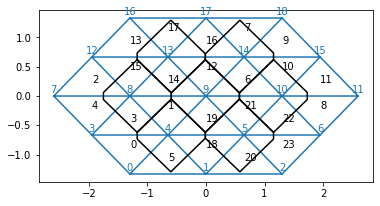

In [ ]:
mesh.cellplot()
mesh.triplot()
mesh.labelplot(face_labels=True)

plt.gca().set_aspect("equal", adjustable="box");

Interesting: scale-free $g_0^{-1}g-1$ energy seems to have a sort of energy barrier towards intercalation.
Wonder why?

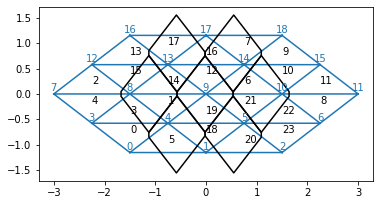

## Creation of initial condition:

- create tri mesh, large
- add noise, compute Delaunay
    - if like, delete or duplicate points to make defects specifically
- create listofpts and faces mesh
- delete points outside desired mask

Want: large rectangular slab and circle.

In [ ]:
#| export

def get_triangular_lattice(nx, ny):
    """get triangular lattice with nx, ny points. Return a mask which delinates bdry vertices""" 

    y = np.arange(0, ny)*sqrt(3)/2
    x = np.arange(nx).astype(float)
    X, Y = np.meshgrid(x, y)
    X -= X.mean()+1/2; Y -=Y.mean()
    X = (X.T+(np.arange(ny)%2)/2).T
    pts = np.stack([X, Y]).reshape((2,nx*ny))
    is_bdry = np.zeros_like(X)
    is_bdry[:1] = is_bdry[-1:] = 1
    is_bdry[:,:1] = is_bdry[:,-1:] = 1
    is_bdry = is_bdry.reshape(nx*ny)
    
    return pts, is_bdry

def create_rect_mesh(nx, ny, noise=0, defects=(0,0)):
    pts, is_bdry = get_triangular_lattice(nx, ny)
    pts[:,~is_bdry.astype(bool)] += np.random.normal(scale=noise, size=(2, (~is_bdry.astype(bool)).sum()))
    if defects[0] > 0:
        ix = np.random.choice(np.where(1-is_bdry)[0], size=defects[0], replace=False)
        pts = np.delete(pts, ix, axis=1)
    if defects[1] > 0:
        pass # to be implemented
    tri = spatial.Delaunay(pts.T)
    # remove the left, right edge
    max_x, min_x = (pts[0].max(), pts[0].min())
    simplices = np.stack([x for x in tri.simplices
                      if (np.isclose(pts[0,x], min_x).sum()<2) and (np.isclose(pts[0,x], max_x).sum()<2)])
    pre_mesh = ListOfVerticesAndFaces(tri.points, simplices)
    mesh = HalfEdgeMesh(pre_mesh)
    
    return mesh

# might want to add the corner pts.

(-3.275, 2.775, -9.049965469547384, 9.049965469547384)

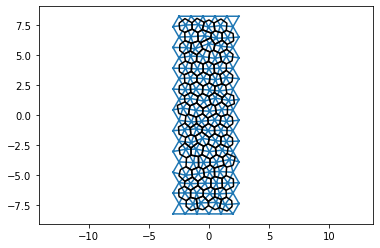

In [ ]:
mesh = create_rect_mesh(6, 20, noise=0.1, defects=(0,0))
mesh.set_voronoi()
mesh.triplot()
mesh.cellplot()

plt.axis("equal")
# in the case of defects, it might be best to re-set the vertex positions by optimizing the
# triangulation with prefered lengths all =1.

## Simulation with boundary conditions and passive & active cells

For starters, simply divide the cells into active $m=4$ and passive, $m=1$. Would be better to make this more gradual ofc.

Note: this is not actually working perfec

Energy based bdry condition method appears much more reasonable

### To - do: In a refactoring step, put the boundary energy back into notebook 3
 Keep tests here though!

In the example of a small "germ band", we get a problem: the fake elasticity we have imposed on the tension triangulation leads to shear "forces" on the central passive region, creating bridges there, too.

Can remove the area-regularization. Does that help?

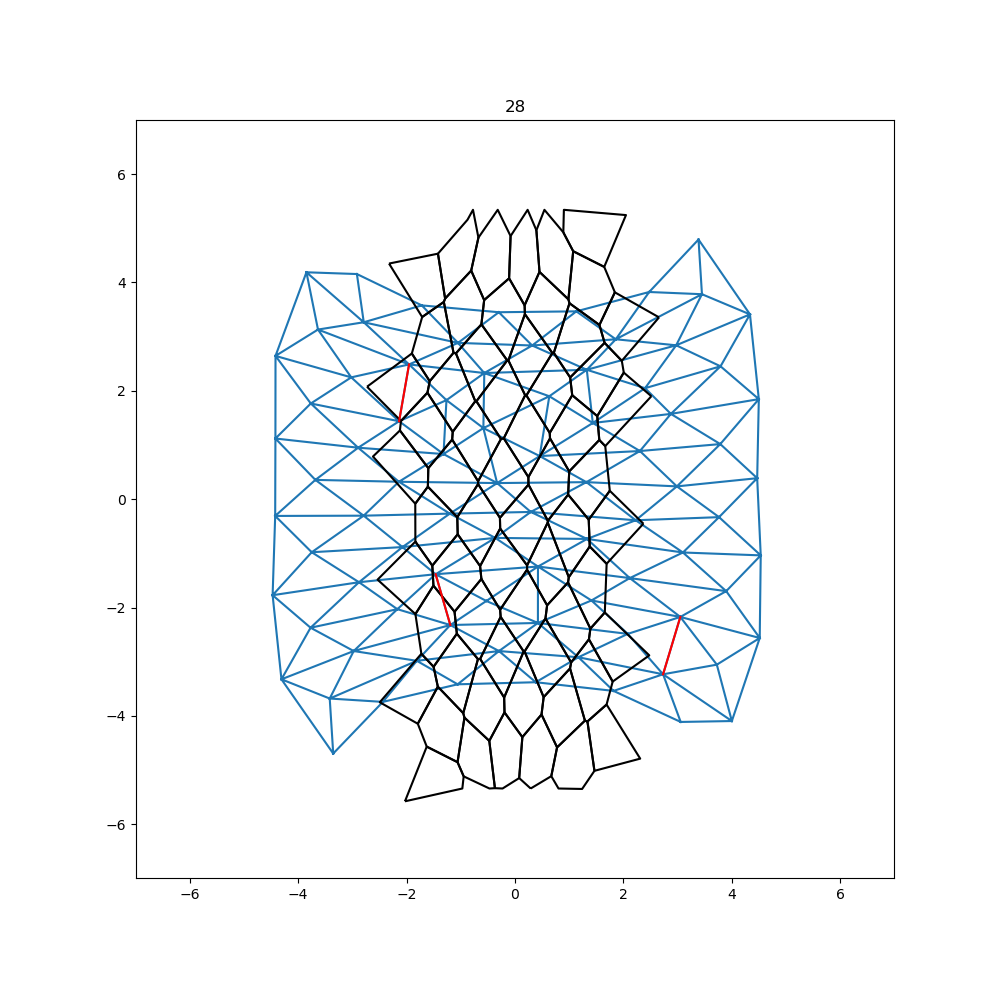

Else, try a germ band with only half a lateral side

In [ ]:
@patch
def euler_step(self: HalfEdgeMesh, dt=.005, rhs=excitable_dt_post, params=None,
               rhs_rest_shape=None):
    """RHS: callable Ts, Tps -> dTs_dt, dTps_dt. Params can either be a dict of keyword args
    to the RHS function, or a callable faceid -> keyword dict.
    rhs_rest_shape: v -> d_rest_shape_dt, for rest shape dynamics (e.g. viscous relaxation)
    """
    rhs_rest_shape = (lambda fc: 0) if rhs_rest_shape is None else rhs_rest_shape
    for fc in self.faces.values():
        # collect edges
        Ts, Tps = (np.array([he.rest for he in fc.hes]), np.array([he.passive for he in fc.hes]))
        if isinstance(params, dict):
            dT_dt, dTp_dt = rhs(Ts, Tps, **params)
        elif callable(params):
            dT_dt, dTp_dt = rhs(Ts, Tps, **params(fc._fid))
        Ts += dt*dT_dt
        Tps += dt*dTp_dt
        for T, Tp, he in zip(Ts, Tps, fc.hes):
            he.rest = T
            he.passive = Tp
    for v in self.vertices.values():
        v.rest_shape += dt*rhs_rest_shape(v)


In [ ]:
@patch
def optimize_cell_shape(self: HalfEdgeMesh, energy_fct_kwargs=None, tol=1e-3, maxiter=250, verbose=True):
    """primal optimization"""
    energy_fct_kwargs = dict() if energy_fct_kwargs is None else energy_fct_kwargs
    get_E, jac = self.get_primal_energy_fct_cells_bdry(**energy_fct_kwargs)
    x0 = self.dual_vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, jac=jac, method="BFGS", tol=tol, options={"maxiter": maxiter})
    if sol["status"] !=0 and verbose:
        print("Cell shape optimization failed", sol["message"])
    new_coord_dict = self.initial_cond_to_dual_vertices(sol["x"])
    for key, val in self.faces.items():
        val.dual_coords = new_coord_dict[key]

In [ ]:
#| export

def excitable_dt_act_pass(Ts, Tps, k=1, m=2):
    """Time derivative of tensions under excitable tension model with constrained area,
    with passive tension for post intercalation. Variant: completely deactivate feedback for m=1"""
    dT_dt = (m-1)*((Ts-Tps)**m - k*Tps)
    dTp_dt = -k*Tps
    area_jac = sides_area_jac(Ts-Tps)
    area_jac /= norm(area_jac)
    dT_dt -= area_jac * (area_jac@dT_dt)
    return dT_dt, dTp_dt


In [ ]:
# 1) no boundary condition -> CE flow as expected. however, the type of boundary
# (not a clean cut) in create_rect_mesh can lead to problems. so use trimesh for a sec
# 2) now try patterned feedback. also looks reasonable. now try plotting the shape energies. done
# 3) now add boundary condition. also works. energy increases!

In [ ]:
#| notest
%matplotlib inline

In [ ]:
# create a mesh, and set passive regions. Need to wrap this as function!

#mesh = create_rect_mesh(5, 9, noise=0.05, defects=(0,0))

mesh = get_tri_hemesh(noise=0.04, ny=9, nx=7)  # try larger noise. workgks for 0 noise

mesh.set_centroid()
for v in mesh.vertices.values():
    v.rest_shape = sqrt(3)*np.eye(2)

mesh.transform_vertices(shear_mat(1.1))
mesh.set_rest_lengths()

# set the boundary conditions and mark the active and passive vertices
passive_ids = []
active_ids = []
bdry_ids = [[],[]]

max_y = np.max([val.dual_coords[1] for val in mesh.faces.values()])
for fc in mesh.faces.values():
    #if (fc.is_bdr() or (fc.dual_coords[1] > .4)) and (not fc.dual_coords[1] < -4.1):
    if np.abs(fc.dual_coords[1]) > 2:
        passive_ids.append(fc._fid)
    else:
        active_ids.append(fc._fid)
    if fc.is_bdr() and fc.dual_coords[1] > max_y-.2:
        bdry_ids[0].append(fc._fid)
    if fc.is_bdr() and fc.dual_coords[1] < -(max_y-.2):
        bdry_ids[1].append(fc._fid)

passive_ids = sorted(passive_ids)
active_ids = sorted(active_ids)
bdry_coords = [("y", max_y), ("y", -max_y)]
bdry_penalty_fcts = [lambda x: (x[1]-max_y)**2, lambda x: (x[1]+max_y)**2]


mesh.triplot()
mesh.cellplot()


for key in passive_ids:
    plt.scatter(*mesh.faces[key].dual_coords, c="r")
for key in bdry_ids[0]:
    plt.scatter(*mesh.faces[key].dual_coords, c="g")
for key in bdry_ids[1]:
    plt.scatter(*mesh.faces[key].dual_coords, c="b")


plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
## set simulation parameters

# function for active and passive
k = 2
def params_pattern(fid):
    if fid in passive_ids:
        return {"k": k, "m": 1}
    return {"k": k, "m": 2}

params_no_pattern = {"k": k, "m": 2}

k_rest = 5
rhs_rest_shape = lambda v: -k_rest*(v.rest_shape-v.get_shape_tensor())

dt = .01
n_steps = 50

minimal_l = .075

mod_bulk = 1
mod_shear = 0.05
angle_penalty = 200

reg_bulk = 0
A0 = sqrt(3)/2  # causes super bizzare optimization problems. need to investigate

epsilon_l = 1e-6

bdry_penalty = 100

forbid_reflip = 40
tol, maxiter = (.5*1e-4, 1000)
cell_shape_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear, "angle_penalty": angle_penalty,
                   "reg_bulk": reg_bulk, "A0": A0,
                   "bdry_ids": bdry_ids,
                   #"bdry_coords": bdry_coords, # energy
                   "bdry_penalty_fcts": bdry_penalty_fcts, "bdry_penalty": bdry_penalty,
                   "epsilon_l": epsilon_l}

In [ ]:
## simulation loop

meshes = []
times = [0]
last_flipped_edges = [[]] # T1_count = np.cumsum([len(x) for x in last_flipped_edge])

mesh.set_voronoi()
#mesh.set_bdry(bdry_ids, bdry_coords)

for i in tqdm(range(n_steps)):    
    # euler step
    mesh.euler_step(dt=dt, rhs=excitable_dt_act_pass, params=params_pattern, rhs_rest_shape=rhs_rest_shape)
    # flatten triangulation
    mesh.flatten_triangulation()
    # primal optimization
    mesh.optimize_cell_shape(energy_fct_kwargs=cell_shape_args, tol=tol, maxiter=maxiter, verbose=True)
    # alternative - set voronoi. is this much different??
    #mesh.set_voronoi()
    #mesh.set_bdry(bdry_ids, bdry_coords)

    # check for intercalation
    primal_lengths = mesh.get_primal_edge_lens(oriented=True)
    flipped = []
    for key, val in primal_lengths.items():
        conditions = (val < minimal_l)
        conditions &= not any([key in x for x in last_flipped_edges[-forbid_reflip:]])
        #conditions &= not (mesh.hes[key].face._fid in passive_ids)
        if conditions:  
            try:
                print(f"flip {key}, tpt {i}")
                he = mesh.hes[key]
                mesh.flip_edge(key)
                mesh.reset_rest_passive_flip(he, method="smooth") # smooth
                f0, f1 = (he.face, he.twin.face)
                f0.dual_coords, f1.dual_coords = rotate_about_center(np.stack([f0.dual_coords, f1.dual_coords]))
                flipped.append(he._heid)
            except ValueError:
                continue
    #if flipped:
    #    mesh.optimize_cell_shape(energy_fct_kwargs=cell_shape_args, tol=tol, maxiter=maxiter, verbose=True)
    #    mesh.set_bdry(bdry_ids, bdry_coords)
    # re-center
    # re-set the rest shapex
    #for v in mesh.vertices.values():
    #    v.rest_shape = v.get_shape_tensor()

    
    
    center = anp.median([v.coords for v in mesh.vertices.values()], axis=0)
    mesh.transform_vertices(lambda x: x-center)
        
    center = anp.median([fc.dual_coords for fc in mesh.faces.values()], axis=0)
    mesh.transform_dual_vertices(lambda x: x-center*np.array([1,0])) 
    # meed to rename that method confusing as it refers to primal vertices I think??

    last_flipped_edges.append(flipped)
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)

last_flipped_edges = last_flipped_edges[1:]
times = np.array(times)[1:]

# 30s if no area reg is used. 46s if non-zero area reg is used
# 1h30min for 19*29

# why is this so much worse behaved than what I had before?

  0%|          | 0/50 [00:00<?, ?it/s]

flip 171, tpt 19
flip 18, tpt 20
flip 51, tpt 22
flip 159, tpt 25
flip 135, tpt 27
flip 165, tpt 33
flip 87, tpt 34
flip 129, tpt 34
flip 54, tpt 35
flip 42, tpt 40
flip 105, tpt 40
flip 3, tpt 41
flip 60, tpt 45
flip 72, tpt 47
flip 189, tpt 49


In [ ]:
#| notest
%matplotlib inline

In [ ]:
# calculate the shape tensor energies

energies = [{key: val for key, val in msh.get_shape_energy().items() if val is not None} for msh in meshes]

(0.0, 0.1)

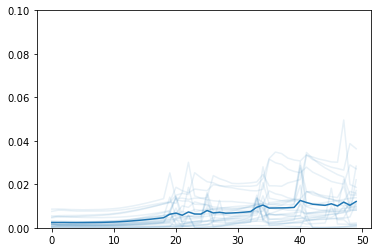

In [ ]:
# time series plot of energies
e_time = np.array([[e[key] for e in energies] for key in energies[0].keys()])
plt.plot(e_time.T, color="tab:blue", alpha=.1);
plt.plot(e_time.mean(axis=0), color="tab:blue", alpha=1);

plt.ylim([0, 1e-1])

# strong relaxation - looks not too bad!

<matplotlib.collections.PathCollection>

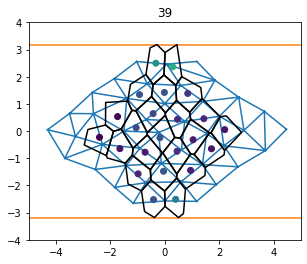

In [ ]:
# spatial plot

i = 39

plt.hlines((max_y, -max_y), (-7, -7), (7, 7), color="tab:orange")
plt.xlim([-5, 5])
plt.ylim([-4, 4])
plt.gca().set_aspect("equal", adjustable="box")
meshes[i].cellplot()
meshes[i].triplot()
plt.title(i);

# now calculate the energies and centroids
for_scttr = np.stack([np.hstack([np.mean([fc.dual_coords
                                  for fc in meshes[i].vertices[key].get_face_neighbors()], axis=0), [val]])
                     for key, val in energies[i].items()], axis=-1)

plt.scatter(*for_scttr[:2], c=for_scttr[2], vmin=0, vmax=5*1e-2)

No relaxation

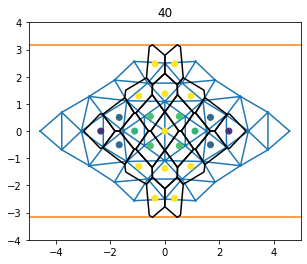

(0.0, 1.7320508075688772)

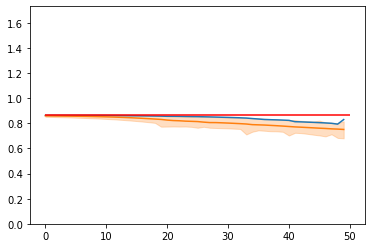

In [ ]:
# create a time-series of areas

areas = np.empty((len(meshes), len(meshes[0].vertices)))
for t, msh in enumerate(meshes):
    for v in msh.vertices.values():
        nghbs = v.get_face_neighbors()
        if (None in nghbs):
            areas[t, v._vid] = np.nan
        else: 
            areas[t, v._vid] = polygon_area(np.stack([fc.dual_coords for fc in nghbs]))
            
areas = areas[:, ~np.isnan(areas).any(axis=0)]

plt.plot(areas[:, 20])
mean = areas.mean(axis=1)

plt.plot(mean)
plt.fill_between(np.arange(areas.shape[0]), np.quantile(areas, .05, axis=1),
                 np.quantile(areas, .95, axis=1), color="tab:orange", alpha=.25)

plt.hlines(A0, 0, len(meshes), color="r")
plt.ylim([0, sqrt(3)])



<IPython.core.display.Javascript object>


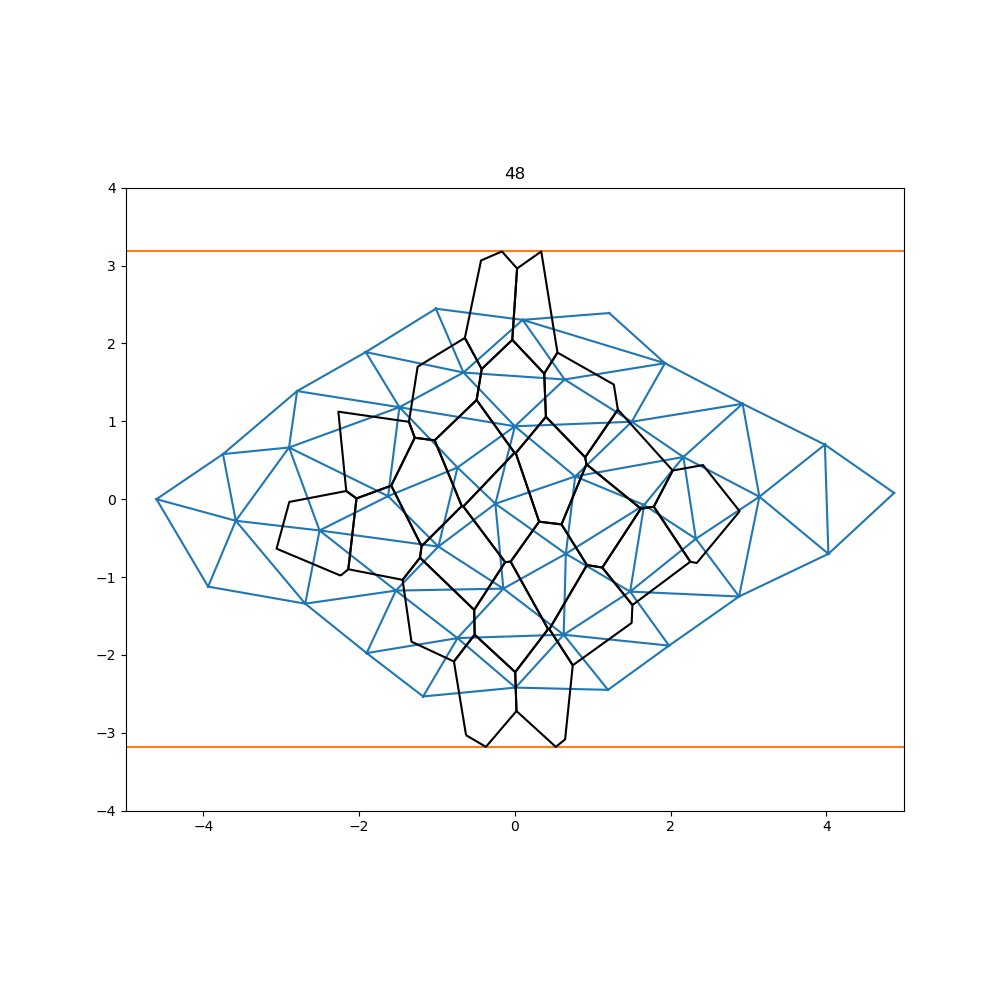

interactive(children=(IntSlider(value=24, description='i', max=48), Output()), _dom_classes=('widget-interact'…

In [ ]:
#| notest
%matplotlib notebook

fig = plt.figure(figsize=(10, 10))

def plot_mesh(i):
    plt.cla()
    plt.hlines((max_y, -max_y), (-7, -7), (7, 7), color="tab:orange")
    plt.xlim([-5, 5])
    plt.ylim([-4, 4])
    plt.gca().set_aspect("equal", adjustable="box")
    meshes[i].cellplot()
    meshes[i].triplot()
    plt.title(i)
    for x in last_flipped_edges[i]:
        he = meshes[i].hes[x]
        line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
        plt.plot(*line.T, c="r")
widgets.interact(plot_mesh, i=(0, n_steps-2, 1));

In [ ]:
#| notest
%matplotlib inline

## Now let's also save it als HTML5 animation - can take a bit of time due to inefficiency

# create the figure and axes objects
fig = plt.figure(facecolor="white", dpi=300)
# animation parameters
nframes, frame_dt = n_steps, 200  # Delay between frames in milliseconds

# function that draws each frame of the animation
def animate_meshes(n):
    plt.cla()
    plt.hlines((max_y, -max_y), (-7, -7), (7, 7), color="tab:orange")
    plt.xlim([-5, 5])
    plt.ylim([-4, 4])
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title('')
    meshes[n].cellplot()
    meshes[n].triplot()
    #for x in last_flipped_edges[i]:
    #    he = meshes[i].hes[x]
    #    line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
    #    plt.plot(*line.T, c="r")
    if n == nframes-1:
        plt.close()

# run the animation
anim = animation.FuncAnimation(fig, animate_meshes, frames=nframes, interval=frame_dt, repeat=False)
anim.save('plots/germ_band_small.mp4', fps=4,)
#extra_args=['-vcodec', 'libx264'])

this looks reasonable:

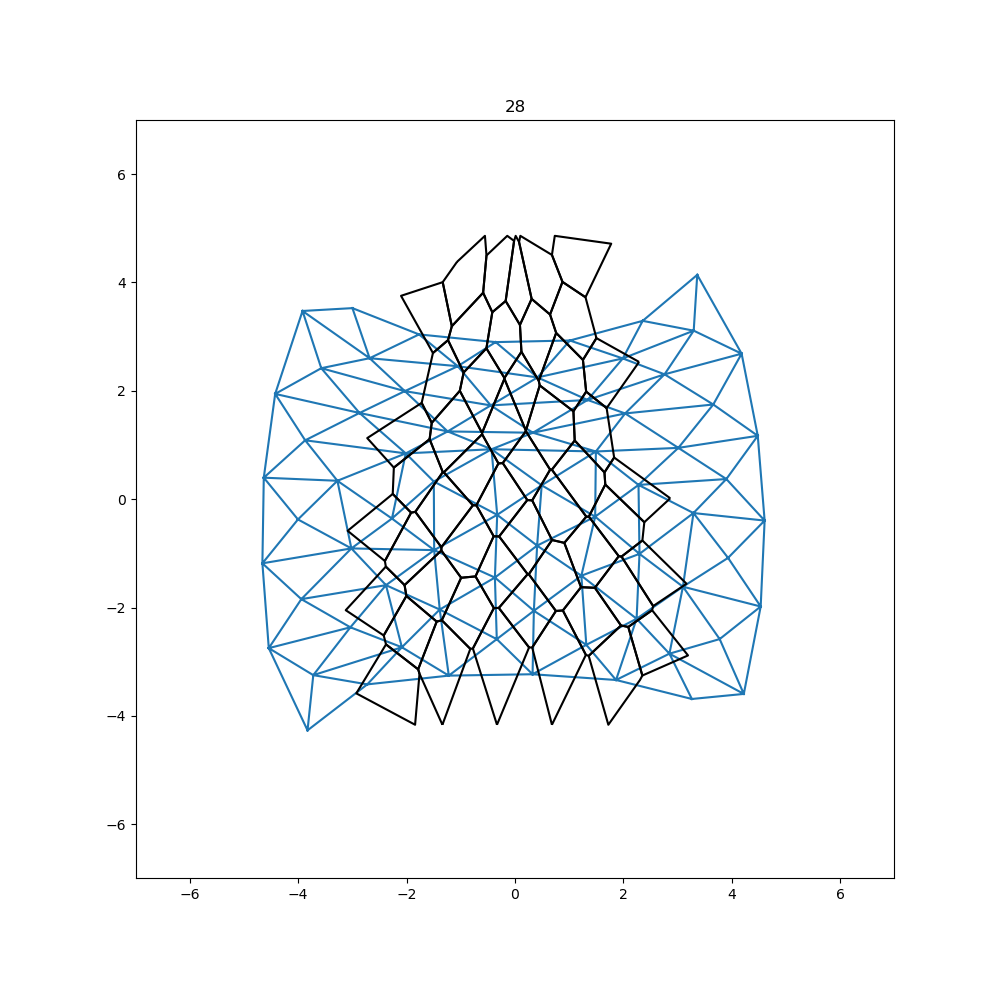

## Code old/ to be reused

In [ ]:
#| notest
# code to create a "germ ban" with both lateral sides

# create a mesh, and set passive regions. all 

mesh = create_rect_mesh(6, 14, noise=0.05, defects=(0,0))
mesh.set_centroid()
for v in mesh.vertices.values():
    v.rest_shape = sqrt(3)*np.eye(2)

mesh.transform_vertices(shear_mat(1.2))
mesh.set_rest_lengths()

# set the boundary conditions and mark the active and passive vertices
passive_ids = []
active_ids = []
bdry_ids = [[],[]]

max_y = np.max([val.dual_coords[1] for val in mesh.faces.values()])
for fc in mesh.faces.values():
    if fc.is_bdr() or np.abs(fc.dual_coords[1]) < 1.5:
        passive_ids.append(fc._fid)
    else:
        active_ids.append(fc._fid)
    if fc.is_bdr() and fc.dual_coords[1] > max_y-.2:
        bdry_ids[0].append(fc._fid)
    if fc.is_bdr() and fc.dual_coords[1] < -(max_y-.2):
        bdry_ids[1].append(fc._fid)

passive_ids = sorted(passive_ids)
active_ids = sorted(active_ids)
bdry_coords = [("y", max_y), ("y", -max_y)]

mesh.triplot()
mesh.cellplot()

for key in passive_ids:
    plt.scatter(*mesh.faces[key].dual_coords, c="r")

for key in bdry_ids[0]:
    plt.scatter(*mesh.faces[key].dual_coords, c="g")
for key in bdry_ids[1]:
    plt.scatter(*mesh.faces[key].dual_coords, c="b")
    
plt.gca().set_aspect("equal", adjustable="box");

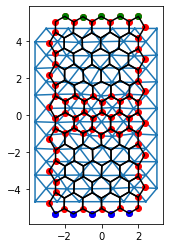